### Objective

We have extracted faces from each image of the dataset and now we have to develop a face recognition model using Tensorflow that can accurately predict the identity of a person based on an input image.

## Libraries

In [45]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator      # To load, augment and preprocess the images 
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, Flatten, BatchNormalization, Input
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import regularizers
from deepface.basemodels import Facenet, OpenFace
from PIL import UnidentifiedImageError
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix

## Parameters

In [2]:
image_height = 160
image_width = 160
num_channels = 3
batch_size = 32
num_classes = 31

## Paths

In [3]:
train_dir = "artifacts/extracted_faces/train"
test_dir = "artifacts/extracted_faces/test"
validation_dir = "artifacts/extracted_faces/validation"

## Load And Preprocess Data

As we have discussed in [Inference 1](data_preparatioin.ipynb) the dataset is imbalenced and we have only few images(<3000). So we have to augment this dataset to make training data more robhust and improve model performance. For this we have an api in tensorflow keras (ImageDataGenerator) which augments images by augmenting images like rotaing, flipping, zoom, etc.. during training

In [4]:
train_datagen = ImageDataGenerator(
    rescale = 1./255,       # Normalize pixel value of the image between 0 and 1
    rotation_range=5,      # rotate images randomly in the range (degrees, 0 to 180)
    width_shift_range=0.1,  # shift images horizontally (fraction of total width)
    height_shift_range=0.1, # shift images vertically (fraction of total height)
    shear_range=0.05,        # shear intensity (shear angle in radians)
    zoom_range=0.05,         # zoom in/out images
    horizontal_flip=True,   # flip images horizontally
    fill_mode='nearest'     # fill mode for points outside the input boundaries
)

In [5]:
val_datagen = ImageDataGenerator(rescale=1./255)      
test_datagen = ImageDataGenerator(rescale=1./255)     # Normalize pixel value of the image between 0 and 1

In [6]:
def generator_with_error_handling(datagen, directory, target_size=(image_height, image_width), batch_size=32, class_mode='categorical'):
    original_generator = datagen.flow_from_directory(
        directory,
        target_size=target_size,
        batch_size=batch_size,
        class_mode=class_mode
    )
    # For handling Unidentified Images
    def error_handling_generator():
        while True:
            try:
                yield next(original_generator)
            except UnidentifiedImageError as e:
                print(f"Skipping image due to error: {e}")

    return original_generator, error_handling_generator()


Note : The Error handling is used to trackle the Unwanted files that are being created on the externel SSD without effecting the training

In [7]:
train_generator, train_generator_with_error_handling = generator_with_error_handling(train_datagen, train_dir)
val_generator, val_generator_with_error_handling = generator_with_error_handling(val_datagen, validation_dir)
test_generator, test_generator_with_error_handling = generator_with_error_handling(test_datagen, test_dir)

Found 2035 images belonging to 31 classes.
Found 278 images belonging to 31 classes.
Found 256 images belonging to 31 classes.


## Model Archetecture

1) To build an effective face recognitioin model, we shall use an ensemble of the state-of-the art face recognition models like FaceNet and OpenFace. 
2) We will use stacking technique to learn the optimal way to combine the predictions from FaceNet and OpenFace Models.

#### Load Pre-trained Models

In [8]:
facenet_model = Facenet.load_facenet128d_model()
openface_model = OpenFace.load_model()

2024-06-05 15:49:40.424414: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1
2024-06-05 15:49:40.424441: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 8.00 GB
2024-06-05 15:49:40.424449: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 2.67 GB
2024-06-05 15:49:40.424469: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-06-05 15:49:40.424495: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
/Volumes/T7/face_recognition/faceenv/lib/python3.11/site-packages/keras/src/layers/reshaping/zero_padding2d.py:72: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a laye

### Extract Features

1) FaceNet model expects an imput image of size (160, 160, 3) whereas the OpenFace model expects an input of size (96, 96, 3)
2) We need to selectively handle the difference of these archetectures and effectively combine predictions of these two models and use them appropriately to make an effecient model that recognize face.

In [9]:
# Function to extract features
# Selectively extract features base on model and data.
def extract_features(model, generator, error_handle_generator, target_size):
    features = []
    labels = []
    sample_count = generator.samples
    batch_size = generator.batch_size

    for _ in range(sample_count // batch_size +1):
        try:
            inputs_batch, labels_batch = next(error_handle_generator)
            inputs_batch = tf.image.resize(inputs_batch, target_size)
            features_batch = model.predict(inputs_batch)
            features.append(features_batch)
            labels.append(labels_batch)
        except StopIteration:
            break
    
    return np.concatenate(features), np.concatenate(labels)

In [10]:
# Extract features using FaceNet
facenet_features, facenet_labels = extract_features(facenet_model, train_generator, train_generator_with_error_handling, (160,160))
facenet_val_features,  facenet_val_labels = extract_features(facenet_model, val_generator, val_generator_with_error_handling, (160,160))

# Extract Features from Openface model
openface_features, openface_labels = extract_features(openface_model, train_generator, train_generator_with_error_handling, (96,96))
openface_val_features, openface_val_labels = extract_features(openface_model, val_generator, val_generator_with_error_handling, (96,96))

2024-06-05 15:49:43.996896: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
Skipping image due to error: cannot identify image file <_io.BytesIO object at 0x35008cd10>
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/s

**Note :** Dont worry that some files are getting skipped in training.
- I am Running this code on an externel SSD 
- The probleum is that, it is creating some duplicate hidden files starting with '._ filename' for some files whenever there is wright operation on it.
- So, for that I have used Error Handling to skip such files when encoutered. 

#### Concatenate the extracted features

In [22]:
train_features = np.concatenate([facenet_features,openface_features],axis=1)
val_features = np.concatenate([facenet_val_features, openface_val_features], axis=1)

In [23]:
train_features.shape

(2035, 256)

In [24]:
val_features.shape

(278, 256)

#### Define Meta-learner classifier
- Use the predictions from the two models as the input features for the meta-classifier.
- The meta-classifier learns to weigh the contributions of the individual models based on their performance on a validation set.

In [25]:
input_shape = train_features.shape[1]
meta_input = Input(shape=(input_shape,))
x = Flatten()(meta_input)
x = BatchNormalization()(x)
x = Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.01))(x)
x = Dropout(0.5)(x)
output = Dense(num_classes, activation='softmax')(x)

#### Defie Model

In [26]:
ensemble_model = Model(inputs=meta_input, outputs=output)

#### Configure Callback
- Early Stopping is a powerful tool that allows you to automatically stop the training process when the model's performance on a validation set stops improving, even before the specified number of training epochs is reached.
-  This is particularly useful when you're not sure how many epochs your model needs to train.

In [27]:
early_stopping = EarlyStopping(monitor='val_loss',patience=5,restore_best_weights=True)

#### Compile the model

In [28]:
ensemble_model.compile(
    optimizer = 'adam',  
    loss = 'categorical_crossentropy',
    metrics = ['accuracy']
)

### Ttraining 

In [29]:
history = ensemble_model.fit(
    train_features,
    facenet_labels,
    epochs = 50,
    batch_size = batch_size,
    validation_data = (val_features, facenet_val_labels),
    callbacks = [early_stopping]
)

Epoch 1/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - accuracy: 0.2704 - loss: 5.3666 - val_accuracy: 0.9640 - val_loss: 2.5086
Epoch 2/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.9339 - loss: 2.5137 - val_accuracy: 0.9748 - val_loss: 1.8744
Epoch 3/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.9782 - loss: 1.8400 - val_accuracy: 0.9784 - val_loss: 1.4124
Epoch 4/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.9836 - loss: 1.3729 - val_accuracy: 0.9820 - val_loss: 1.0463
Epoch 5/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.9874 - loss: 1.0020 - val_accuracy: 0.9784 - val_loss: 0.7711
Epoch 6/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.9916 - loss: 0.7406 - val_accuracy: 0.9820 - val_loss: 0.5749
Epoch 7/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.9944 - loss: 0.5556 - val_accuracy: 0.9856 - val_loss: 0.4408
Epoch 8/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.9960 - loss: 0.4281 - val_accuracy: 0.9892 - v

## Ploting Model Performance

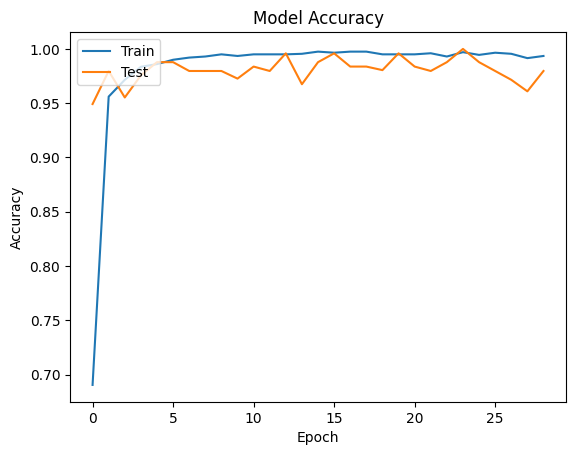

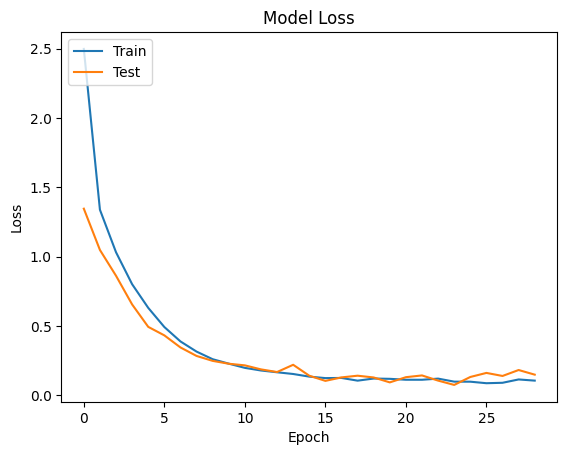

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train','Test'],loc="upper left")
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train','Test'],loc="upper left")
plt.show()

We can observe a trade-off  between training training and testing loss and a steady decrease implying a promising a good performance.

-->  We need to evaluate the model with unseen test data to infer how the model generalizes and perform in the real world senario

## Evaluation

#### Extract Features of test Images

In [33]:
def generate_features(generator, generator_with_error_handling):
    # Extract facenet Features
    facenet_features, facenet_labels = extract_features(facenet_model, generator, generator_with_error_handling, (160,160))
    openface_features, openface_labels = extract_features(openface_model, generator, generator_with_error_handling, (96,96))

    # Concatenate features
    combined_features = np.concatenate([facenet_features,openface_features],axis=1)

    return combined_features, facenet_labels
    


In [34]:
test_features, true_labels = generate_features(test_generator, test_generator_with_error_handling)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 264ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


In [35]:
true_labels.shape

(288, 31)

#### Predict extracted test Features


In [36]:
predicted_labels = ensemble_model.predict(test_features)

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


In [37]:
predicted_labels.shape

(288, 31)

### Evaluate the model performance on unseen data

In [38]:
true_labels = np.argmax(true_labels, axis=1)
predicted_labels = np.argmax(predicted_labels, axis=1)

##### Confusion Matrix 

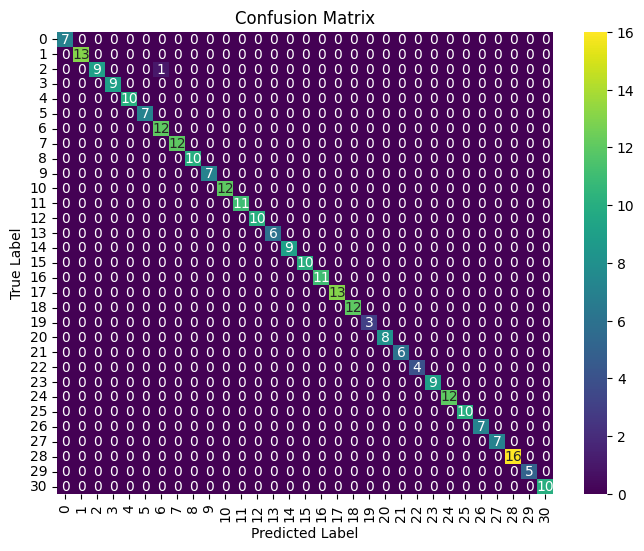

In [43]:
cm = confusion_matrix(y_true=true_labels, y_pred=predicted_labels)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap="viridis")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

##### Classification Report

In [44]:
target_names = os.listdir(train_dir)

print("\nClassification Report:")
print(classification_report(y_true=true_labels, y_pred=predicted_labels, target_names=target_names))


Classification Report:
                    precision    recall  f1-score   support

       Virat Kohli       1.00      1.00      1.00         7
     Roger Federer       1.00      1.00      1.00        13
      Akshay Kumar       1.00      0.90      0.95        10
  Robert Downey Jr       1.00      1.00      1.00         9
         Brad Pitt       1.00      1.00      1.00        10
   Ellen Degeneres       1.00      1.00      1.00         7
       Lisa Kudrow       0.92      1.00      0.96        12
      Courtney Cox       1.00      1.00      1.00        12
       Claire Holt       1.00      1.00      1.00        10
  Amitabh Bachchan       1.00      1.00      1.00         7
        Tom Cruise       1.00      1.00      1.00        12
    Hrithik Roshan       1.00      1.00      1.00        11
            Marmik       1.00      1.00      1.00        10
     Billie Eilish       1.00      1.00      1.00         6
      Andy Samberg       1.00      1.00      1.00         9
      Hugh Jack

# Inference 

- We can observe that our Model performed very well on the unseen data as well proving its generalization capability in predicting faces
- Our model predicted almost all faces correctly except two pictures of akshay kumar 
- Inspite of high accuracy over training (98.2) the model performed exceptionally well on the new unseen test data by giving precision, recall, f1score of almost all classes equal to 1. making it more reliable at recognizing face

## Save the meta-learner

- This meta-learner is trained to effectively weigh the features form the state-of-the-art face recognition models like FaceNet and OpenFace.
- We can use this model to recoginse a person based on the features extracted from those pre-trained models.

In [46]:
ensemble_model.save('ensemble_meta_learner.h5')